In [175]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import constants 
from scipy.interpolate import CubicSpline
import solarpy as sp
import pandas as pd
import seaborn as sns

# Import Meteostat library and dependencies
from datetime import datetime,timedelta
from meteostat import Hourly, Stations

Simulation variables

In [176]:
# Set time period
n_days = 3 #set how many days must be simulated 

#Set start date 
# Warmest day = 8,7,2023
# Ice day: 13-12-2022 (ampbient temp < 0 degrees C) https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/2022/december#:~:text=Koud%20tot%20en%20met%2018,dagen%20het%20hele%20etmaal%20vriezen.
# Shortest day = 21-12-20xx
start_day = 13
start_month= 12
start_year= 2022

#Vessel variables
#rho_vessel = 2.7e3 # aluminium [kg/m3]
rho_vessel = 1.455e3 # Pet [kg/m3] Source: https://plasticranger.com/density-of-pet-plastic/#:~:text=The%20density%20of%20PET%20plastic%20is%201.38%20g%2Fcm%C2%B3%20and,(1.2%20g%2Fcm3).
t_vessel = 0.5e-3 # Thickness [m]
#c_vessel = 890 #J/kg aluminium
c_vessel = 1030 #J/kg Pet Source: https://www.engineeringtoolbox.com/specific-heat-polymers-d_1862.html

#Assumptions
A_factor=0.5 #Assume half of the area of the vessel is exposed to sunlight 
e = 0.9 # emissvity factor black epoxy
alpha=100#[W/M^2K] Convection heat transfer coeficient
P_crit=1e3 #[pa] critical pressure where the hysterical valve opens
cloud_factor = 0.01 # 1 = sunny, 0 = dark 


Simulation constants

In [177]:
#Constants
#Vessel properties 
#D = 0.3 #Diameter vessel
D = np.linspace(0.05,0.3,3) #Diameter vessel
L = np.linspace(0.05,0.3,3) #Lenght vessel

# Create a 2-D grid for D and L
D, L = np.meshgrid(D, L)

# Now D and L are 2-D arrays containing all combinations of diameter and length
V = D**2/4*np.pi*L  # [m^3]
A = D*L + D**2/4*np.pi  # [m^2]

#Air 
rho_air=1.293 #kgm-3 
m_air = rho_air*V #[kg]
R = constants.R #J/K*molz ideal gas constant 
c_air = 718 #j/kg K constant volume
n_mass = 28.96747 #molar mass [g/mol]
n = m_air/n_mass #Amount of mol air 
sigma = constants.sigma #Boltzman constant 

cp = 1000 #J/kgK @ 300 K
cv = 718 #J/kgK @ 300k
y = cp/cv 
K = 273.15 #Kelvin 

#Combined properties
m_vessel = A*t_vessel*rho_vessel
m = m_vessel+m_air #kg
c = m_vessel/m*c_vessel+m_air/m*c_air #j/kg K 

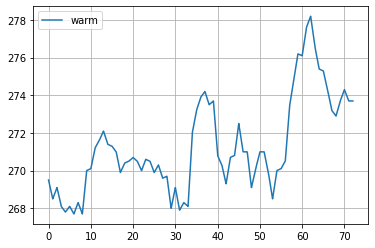

In [178]:
#Import weather data and extract temperature and pressure

# Get nearby weather stations
stations = Stations()
lat = 52.36
lon = 4.94

#statins = stations.nearby(52.35660593196212, 4.948958216497039)
stations = stations.nearby(lat, lon)
station = stations.fetch(1)

# Print DataFrame
#print(station)

# Set time period
start1 = datetime(start_year, start_month, start_day)
end1 = start1 + timedelta(days=n_days)

# Get hourly data
data_warm = Hourly(station, start1, end1)
data_warm = data_warm.fetch()

# Print DataFrame
#print(data_warm)

# Set time period
start2 = datetime(2022, 12, 13) #Coldest day https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/2023/winter
end2 = datetime(2022, 12, 14)

# Get hourly data
data_cold = Hourly(station, start2, end2)
data_cold = data_cold.fetch()

# Create an array for each hour in the day, converted to seconds
dt=1 # Second
day_length = n_days*24 * 60 * 60  # length of a day in seconds
time_steps = np.linspace(0, day_length, num=day_length // dt + n_days)  # time steps
hours = np.arange(n_days*24)*60*60

# Interpolate the temperature data to a per-second basis
T_amb_w = np.interp(time_steps, hours, data_warm['temp'][0:len(hours)].values+273) #[K] w stands for warmest day
#T_amb_c = np.interp(time_steps, hours, data_cold['temp'][0:len(hours)].values)
P_amb = np.interp(time_steps, hours, data_warm['pres'][0:len(hours)].values*100) #Ambient pressure in [pa]

# Plot the data
plt.plot(time_steps/3600, T_amb_w,label='warm')
#plt.plot(time_steps/3600, T_amb_c,label='cold')
plt.grid()
plt.legend()
plt.show()


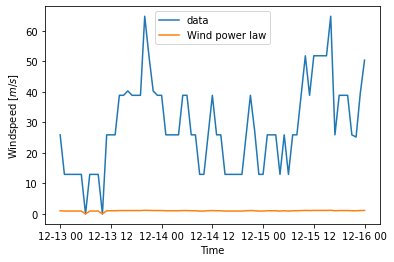

In [179]:
v_wind_plot = (data_warm['wspd']*3.6*(0.1/2))**(1/7)
plt.plot(data_warm['wspd']*3.6,label='data')
plt.ylabel('Windspeed [$m/s$]')
plt.xlabel('Time')
plt.plot(v_wind_plot,label='Wind power law')
plt.legend()

In [180]:
data_warm

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2022-12-13 00:00:00,-3.5,-4.8,91.0,0.0,NaN,140.0,7.2,9.3,1012.6,NaN,1.0
2022-12-13 01:00:00,-4.5,-5.0,96.0,0.0,NaN,160.0,3.6,7.0,1012.2,NaN,1.0
2022-12-13 02:00:00,-3.9,-4.4,96.0,0.0,NaN,130.0,3.6,7.0,1012.2,NaN,1.0
2022-12-13 03:00:00,-4.9,-5.3,97.0,0.0,NaN,100.0,3.6,9.3,1011.9,NaN,1.0
2022-12-13 04:00:00,-5.2,-5.5,98.0,0.0,NaN,80.0,3.6,7.0,1011.7,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-15 20:00:00,-0.1,-0.5,97.0,0.1,NaN,200.0,10.8,18.0,1008.3,NaN,8.0
2022-12-15 21:00:00,0.7,0.6,99.0,0.1,NaN,190.0,7.2,13.0,1008.9,NaN,8.0
2022-12-15 22:00:00,1.3,0.9,97.0,0.0,NaN,324.0,7.0,14.0,1009.3,NaN,7.0


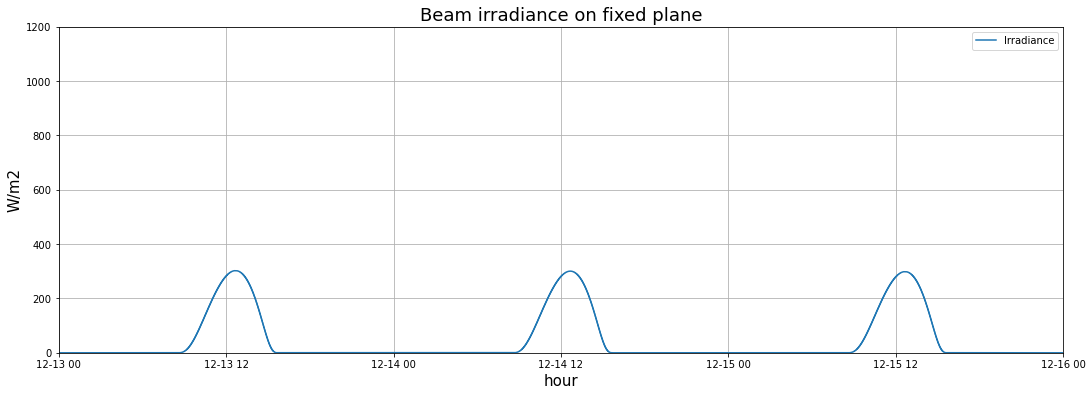

In [181]:
#Extract solar intensity data 

def plot_irradiance(n_days, start_day, lat=lat, vnorm=np.array([-1, -1, -1])): #vnorm is a vector facing south 
    fig, ax = plt.subplots(figsize=(18, 6))
    
    all_t = np.array([])
    all_G = np.array([])
    
    for n in range(n_days):
        #Extract the intensity for a day
        delta_t = start_day + timedelta(days=n)
        t = np.array([delta_t + timedelta(seconds=i) for i in range(0, 24 * 60*60+1, 1)])  # One data point per second
        G = np.array([sp.irradiance_on_plane(vnorm, 0, i, lat) for i in t])

        #Append it to make it one vector of multiple days
        all_t = np.concatenate((all_t, t)) #Concentate is the np equivallent of append
        all_G = np.concatenate((all_G, G))

    plt.plot(all_t, all_G, label='Irradiance')

    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0, 1200)
    plt.xlabel('hour', fontsize=15)
    plt.ylabel('W/m2', fontsize=15)
    plt.title('Beam irradiance on fixed plane', fontsize=18)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return all_G  # Return the array of irradiance values

# Use the function and store the result
solar_constants = plot_irradiance(n_days, start1)

In [182]:
# Find the dimensions of A_exposed
num_rows, num_cols = A.shape
A_exposed= A_factor*A

# Initialize arrays with zeros
v_flow = np.zeros((num_rows, num_cols))
P_all = np.zeros((num_rows, num_cols, day_length+n_days)) 
T_all = np.zeros((num_rows, num_cols, day_length+n_days)) 
Q_rad_all= np.zeros((num_rows, num_cols, day_length+n_days)) 
Q_con_all= np.zeros((num_rows, num_cols, day_length+n_days)) 
v_expelled_all= np.zeros((num_rows, num_cols, day_length+n_days)) 
v_in_all= np.zeros((num_rows, num_cols, day_length+n_days)) 
D2= np.zeros((num_rows, num_cols))
gas_expelled = np.zeros((num_rows, num_cols))

# Loop over all elements of A_exposed
for ii in range(num_rows):
    for jj in range(num_cols):
        #Initialize arrays for this configuration. 
        #ii=jj=1
        T   = np.zeros(day_length+n_days)
        P   = np.zeros(day_length+n_days)
        Q_rad = np.zeros(day_length+n_days)
        Q_con = np.zeros(day_length+n_days)
        n_mol = np.zeros(day_length+n_days)
        v_expelled = np.zeros(day_length+n_days)
        v_in = np.zeros(day_length+n_days)

        #Caclulate heat transfer coefficients for this configuration

        knu = 15.89e-6 #[m^2/s]
        k_air = 26.3e-3 #W/(m*K)
        Pr = 0.707 #dimensionless 

        h = []
        for aa in range(len(data_warm['wspd'])):
            #Correlate the wind measurement to wind speed at 0.1 m above the ground with the wind profile power law 
            v_wind = data_warm['wspd'][aa]*3.6*(0.1/2)**(1/7)

            #Use formula 7.5s from the fundamentals of heat and mass transfer
            Re = v_wind*3.6*D[1,1]/knu
            C = 0.26
            m_air_alpha = 0.6
            Nu = C*Re**m_air_alpha*Pr**(1/3)
            h.append(Nu*k_air/D[ii,jj])         
        
        #Interpolate hour heat transfer coefficient data to seconds
        alpha_hour = np.interp(time_steps, hours,h[0:len(hours)]) 

        for i in range(len(time_steps)):
            # i = the timestep
            if i==0:
                #set starting pressure, temperature and calculate amount of mol
                T[i] = T_amb_w[i] 
                P[i] = P_amb[i]
                n_mol[i] = P[i]*V[ii,jj]/(R*T[i])
            else:
                #print(i)
                #Calculte radiative heat loss with boltzmann formula 
                Q_rad[i]=e*sigma*A[ii,jj]*(T[i-1]**4-T_amb_w[i] **4)

                #Calculate convection heat loss
                Q_con[i]=alpha_hour[i]*A[ii,jj]*(T[i-1]-T_amb_w[i] )

                #Calculate energy received by the sun 
                P_sun = solar_constants[i]*cloud_factor*A_exposed[ii,jj]*dt

                # rewrite Q = mcdT to T where Q is the resulting energy. 
                T[i] = (P_sun-Q_rad[i]-Q_con[i]) /(m[ii,jj]*c[ii,jj])+T[i-1]

                #Update the pressure with new temperature
                P[i] = T[i]/T[i-1]*P[i-1]

                #As check, calculate if the amount of mol stays the same 
                n_mol[i] = P[i]*V[ii,jj]/(R*T[i])

                #If no volume out or in, it stays the same as the previous timestep
                v_expelled[i]=v_expelled[i-1]
                v_in[i]=v_in[i-1]

                # If the pressure difference is high enough, the hysterical valve will open
                if P[i] >= P_amb[i] +P_crit:

                    #Subtract the critical pressure to obtain new pressure
                    P[i] -= P_crit

                    #Update the amount of mol with new pressure 
                    n_mol[i] = P[i]*V[ii,jj]/(R*T[i])

                    #Update temperature 
                    T[i]=(P[i-1]/P[i])*(n_mol[i]/n_mol[i-1])*T[i-1]

                    # Update mass of the system and calculate the specific heat
                    m_air[ii,jj]=n_mass*n_mol[i]
                    m[ii,jj]=m_vessel[ii,jj]+m_air[ii,jj]
                    c[ii,jj] = m_vessel[ii,jj]/m[ii,jj]*c_vessel+m_air[ii,jj]/m[ii,jj]*c_air

                    #Calculate how much air is expelled with the ideal gas law
                    v_expelled[i]=v_expelled[i]+ ((n_mol[i-1]-n_mol[i])*R*T_amb_w[i] /P_amb[i])*1000
                    #T[i] = ((P[i]/P_amb)**(1-y)*T[i]**y)**(1/y)

                # If the pressure is lower than ambient pressure, a one way valve will let in new air
                elif P[i]<=0.9999*P_amb[i]:
                    #Update pressure
                    P[i]=P_amb[i]

                    #Rest of the procedure is the same as in the previous if statement
                    n_mol[i] = P[i]*V[ii,jj]/(R*T[i])
                    T[i]=(P[i-1]/P[i])*(n_mol[i]/n_mol[i-1])*T[i-1]
                    m_air[ii,jj]=n_mass*n_mol[i]
                    m[ii,jj]=m_vessel[ii,jj]+m_air[ii,jj]
                    c[ii,jj] = m_vessel[ii,jj]/m[ii,jj]*c_vessel+m_air[ii,jj]/m[ii,jj]*c_air
                    v_in[i]=v_in[i]+ ((n_mol[i-1]-n_mol[i])*R*T_amb_w[i] /P_amb[i])*1000
                
                #Final time step: print huray
                elif i == len(time_steps)-1:
                    print('huray')
                    
        # Store in array for this ii, jj combination for plotting purposes 
        P_all[ii, jj, :] = P    
        T_all[ii, jj, :] = T   
        Q_rad_all[ii, jj, :] = Q_rad    
        Q_con_all[ii, jj, :] = Q_con  
        v_expelled_all[ii,jj,:]=v_expelled
        v_in_all[ii,jj,:]=v_in

huray
huray
huray
huray
huray
huray
huray
huray
huray


In [183]:
print(hours.shape)
print(h[0:len(hours)])
print(range(len(data_warm['wspd'])))


(72,)
[63.56359412894584, 41.93633264515077, 41.93633264515077, 41.93633264515077, 41.93633264515077, 41.93633264515077, 0.0, 41.93633264515077, 41.93633264515077, 41.93633264515077, 0.0, 63.56359412894584, 63.56359412894584, 63.56359412894584, 81.07056529989121, 81.07056529989121, 82.85901412213501, 81.07056529989121, 81.07056529989121, 81.07056529989121, 110.14694370721386, 96.3443926481863, 82.85901412213501, 81.07056529989121, 81.07056529989121, 63.56359412894584, 63.56359412894584, 63.56359412894584, 63.56359412894584, 81.07056529989121, 81.07056529989121, 63.56359412894584, 63.56359412894584, 41.93633264515077, 41.93633264515077, 63.56359412894584, 81.07056529989121, 63.56359412894584, 63.56359412894584, 41.93633264515077, 41.93633264515077, 41.93633264515077, 41.93633264515077, 41.93633264515077, 63.56359412894584, 81.07056529989121, 65.65942927158386, 41.93633264515077, 41.93633264515077, 63.56359412894584, 63.56359412894584, 63.56359412894584, 41.93633264515077, 63.56359412894

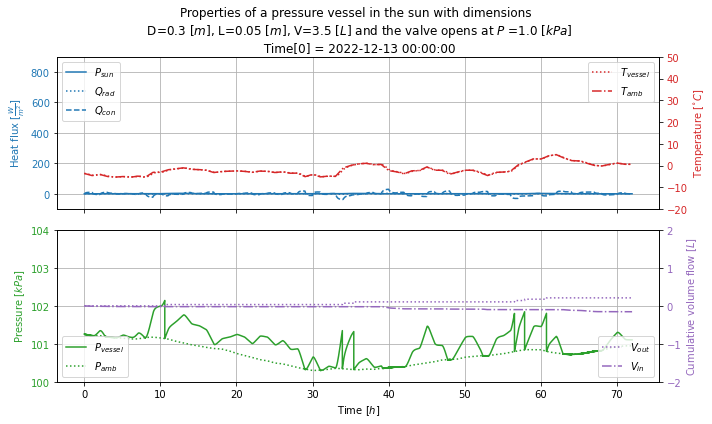

In [193]:
#set which combination you want to plot

#for ii in range(num_rows):
    #for jj in range(num_cols):

ii=0
jj=2
fig, axs = plt.subplots(2, 1,figsize=(10, 6), sharex=True) 
# Plot the solar_constants on the primary y-axis of the first subplot
color = 'tab:blue'
axs[0].set_ylabel('Heat flux' r' $[\frac{W}{m^2}]$', color=color)
axs[0].set_ylim(-100,900)
axs[0].tick_params(axis='y', labelcolor=color)
line1, = axs[0].plot(time_steps/3600, solar_constants*cloud_factor, color=color, label='$P_{sun}$')
line2, = axs[0].plot(time_steps/3600, Q_rad_all[ii,jj,:]/A[ii,jj], color=color,linestyle=':',label='$Q_{rad}$')  
line3, = axs[0].plot(time_steps/3600, Q_con_all[ii,jj,:]/A[ii,jj], color=color,linestyle='--',label='$Q_{con}$')

# Create a second y-axis that shares the same x-axis, and plot T on this axis
ax2 = axs[0].twinx() 
color = 'tab:red'
ax2.set_ylabel('Temperature [$^{\circ}C$]', color=color) 
line4, = ax2.plot(time_steps/3600, T_all[ii,jj,:]-K, color=color,linestyle=':',label='T_tank')
line5, = ax2.plot(time_steps/3600, T_amb_w-K, color=color,linestyle='-.',label='T_air')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-20,50)

# Add a legend manually
axs[0].legend([line1, line2, line3], ['$P_{sun}$', '$Q_{rad}$', '$Q_{con}$'], loc='upper left')
ax2.legend([line4, line5], ['$T _{vessel}$', '$T_{amb}$'], loc='upper right')


plt.title(f"Properties of a pressure vessel in the sun with dimensions \n D={round(D[ii,jj], 2)} [$m$], L={L[ii,jj]} [$m$],\
 V={round(V[ii,jj]*1000,1)} [$L$] and the valve opens at $P$ ={P_crit/1000} [$kPa$] \n Time[0] = {start1}")

#plt.title(f"Properties of a pressure vessel in the sun with dimensions \n D={round(D[ii,jj], 2)} [m], L={round(L[ii,jj], 2)} [m], V={V[ii,jj]*1000}[L] and the valve opens at $P$ ={P_crit/1000} [kPa]")
        
    

# Plot P on the primary y-axis of the second subplot
color = 'tab:green'
axs[1].set_ylabel('Pressure [$kPa$]', color=color)
axs[1].set_ylim(100,104)
line6, = axs[1].plot(time_steps/3600, P_all[ii,jj,:]/1000, color=color)
line7, = axs[1].plot(time_steps/3600, P_amb/1000, color=color,linestyle=':')  # Assuming P is your pressure data
axs[1].tick_params(axis='y', labelcolor=color)

#axs[0].legend(loc='upper left', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
#ax2.legend(loc='upper left', bbox_to_anchor=(1.2, 0.5), borderaxespad=0.)

# Create a second y-axis for the second subplot, and plot Q_rad on this axis
ax4 = axs[1].twinx()
color = 'tab:purple'
line8, = ax4.plot(time_steps/3600, v_expelled_all[ii,jj,:], color=color,linestyle=':',label='$V_{out}$')  
line9, = ax4.plot(time_steps/3600, v_in_all[ii,jj,:], color=color,linestyle='-.',label='$V_{in}$') 

ax4.legend([line8, line9], ['$V_{out}$', '$V_{in}$'], loc='lower right')
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_ylabel('Cumulative volume flow [$L$]', color=color)
ax4.set_ylim(-2, 2)


# Add a legend manually for the second subplot
axs[1].legend([line6,line7], ['$P_{vessel}$', '$P_{amb}$'], loc='lower left')

# ax4 doesn't have any lines plotted, so we don't need to add a legznd for it
#plt.legend()

axs[1].set_xlabel('Time [$h$]')

# Show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
axs[0].grid(True)
axs[1].grid(True)

        #Save the figure
plt.savefig(f"figures/figure_D={round(D[ii,jj], 2)}_L={round(L[ii,jj], 2)}_V={round(V[ii,jj]*1000, 2)}_P={P_crit/1000}.svg",dpi=200)

#Show the last one
#plt.show()


In [185]:
fakevar = 2.34
print('%3.1e, %3.1f,'%(fakevar, fakevar*2))

2.3e+00, 4.7,


       D      L          V  v_expelled
0  0.050  0.050   0.098175    0.006827
1  0.175  0.050   1.202641    0.083671
2  0.300  0.050   3.534292    0.210824
3  0.050  0.175   0.343612    0.023895
4  0.175  0.175   4.209243    0.251123
5  0.300  0.175  12.370021    0.738777
6  0.050  0.300   0.589049    0.040963
7  0.175  0.300   7.215846    0.430617
8  0.300  0.300  21.205750    1.267063


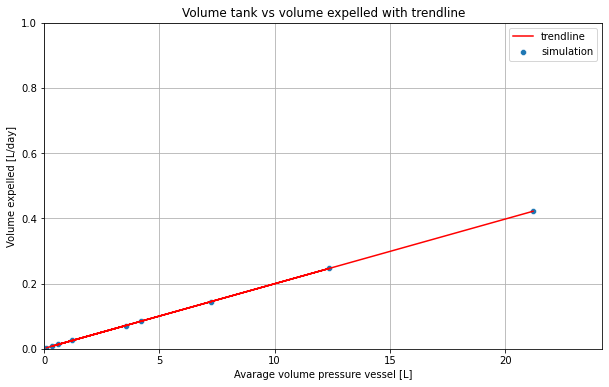

In [186]:
#Make summarizing table

# Initialize data of lists.
data = {'D': D.flatten(), #flatten makes a vector from a array 
        'L': L.flatten(),
        'V': V.flatten()*1000,
        'v_expelled': v_expelled_all[:, :, -1].flatten()}

# Create DataFrame.
df = pd.DataFrame(data)

# Print the output.
print(df)

#Plot linear trend between volume and volume output 
V_linear = df['V']
v_expelled_l = df['v_expelled']/n_days #devide by amount of days to get daily avarage 

# Fit a trend line
slope, intercept = np.polyfit(V_linear, v_expelled_l, 1)
trendline = slope * V_linear + intercept

# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(V_linear, v_expelled_l,label='simulation')
plt.plot(V_linear, trendline, color='red',label='trendline')

# Labels
plt.xlabel('Avarage volume pressure vessel [L]')
plt.ylabel('Volume expelled [L/day]')
plt.title('Volume tank vs volume expelled with trendline')
plt.ylim(0,1)
plt.xlim(0,max(df['V'])+3)
plt.legend()
plt.grid()
plt.savefig(f"figures/linear_relation.svg")

plt.show()

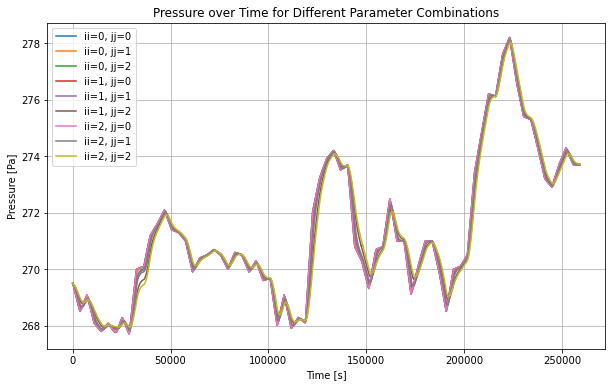

In [187]:
# All the pressures over time. Slightly different because of the hysterical valve
# Set up the plot
plt.figure(figsize=(10, 6))

# Loop over all elements of A_exposed
for ii in range(num_rows):
    for jj in range(num_cols):
        plt.plot(time_steps, T_all[ii, jj, :], label=f"ii={ii}, jj={jj}")

plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')
plt.title('Pressure over Time for Different Parameter Combinations')
plt.legend()  # Show a legend
plt.grid(True)
plt.show()

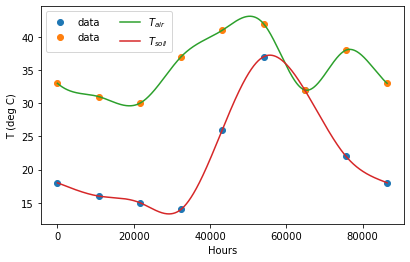

In [188]:
#Fit soil T data from paper
#https://geothermal-energy-journal.springeropen.com/articles/10.1186/s40517-017-0082-z
Time_fit = np.linspace(0,24*3600,9)
T_a = [33,31,30,37,41,42,32,38,33]
T_s = [18,16,15,14,26,37,32,22,18]


T_soil = CubicSpline(Time_fit, T_s,bc_type='periodic')
T_air = CubicSpline(Time_fit, T_a,bc_type='periodic')
xs = np.arange(0,24*3600, 0.1)

fig, ax = plt.subplots(figsize=(6.5, 4))

ax.plot(Time_fit,T_s, 'o', label='data')
ax.plot(Time_fit,T_a, 'o', label='data')
ax.plot(xs, T_air(xs), label="$T_{air}$")
ax.plot(xs, T_soil(xs), label="$T_{soil}$")

ax.legend(ncol=2)
plt.xlabel('Hours')
plt.ylabel('T (deg C)')

plt.show()

In [189]:
#Heat transfer coefficient 
#Assume air = 300K
knu = 15.89e-6 #[m^2/s]
k_air = 26.3e-3 #W/(m*K)
Pr = 0.707 #dimensionless 

h = []
for aa in range(len(data_warm['wspd'])):
    Re = data_warm['wspd'][aa]*3.6*D[1,1]/knu
    C = 0.26
    m_air_alpha = 0.6
    Nu = C*Re**m_air*Pr**(1/3)
    h.append(Nu*k_air/D[1,1])  
print(h)

alpha_hour = np.interp(time_steps, hours,h[0:len(hours)]) 
plt.plot(alpha_hour)
#plt.plot(h)
    

[array([[1.70249332e-001, 9.70212051e+006, 2.27721432e+023],
       [9.00673217e+000, 1.24981450e+028, 2.46681897e+085],
       [4.76467567e+002, 1.61920663e+049, 2.54775024e+147]]), array([[1.55971735e-001, 3.31797712e+006, 9.72984690e+021],
       [6.62869878e+000, 2.92436469e+026, 3.97964869e+080],
       [2.81705805e+002, 2.59137802e+046, 1.55601086e+139]]), array([[1.55971735e-001, 3.31797712e+006, 9.72984690e+021],
       [6.62869878e+000, 2.92436469e+026, 3.97964869e+080],
       [2.81705805e+002, 2.59137802e+046, 1.55601086e+139]]), array([[1.55971735e-001, 3.31797712e+006, 9.72984690e+021],
       [6.62869878e+000, 2.92436469e+026, 3.97964869e+080],
       [2.81705805e+002, 2.59137802e+046, 1.55601086e+139]]), array([[1.55971735e-001, 3.31797712e+006, 9.72984690e+021],
       [6.62869878e+000, 2.92436469e+026, 3.97964869e+080],
       [2.81705805e+002, 2.59137802e+046, 1.55601086e+139]]), array([[1.55971735e-001, 3.31797712e+006, 9.72984690e+021],
       [6.62869878e+000, 2.92

ValueError: object too deep for desired array